In [1]:
import numpy as np
import pandas as pd
import time
import random
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report
from tqdm import tqdm
import torch
from torch import nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
import tenseal as ts

In [36]:
df = pd.read_csv(r"C:\Users\manig\Downloads\Mitacs\top_feature_df_rfr40.csv")
grouped = df.groupby('Label')
df = grouped.apply(lambda x: x.sample(grouped.size().min(), random_state=73).reset_index(drop=True))
x = df.drop(["Label"], axis = 1)
y = df["Label"]
# scaler = preprocessing.MinMaxScaler()
scaler = preprocessing.StandardScaler()
x = scaler.fit_transform(x)
x_train, x_test_20, y_train, y_test_20 = train_test_split(x, y, test_size=0.005, random_state=42)
x_train=torch.from_numpy(x_train).float()
x_test_20=torch.from_numpy(x_test_20).float()
y_train=torch.from_numpy(np.array(y_train)).float().unsqueeze(1)
y_test_20=torch.from_numpy(np.array(y_test_20)).float().unsqueeze(1)
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test_20.shape}")
print(f"y_test shape: {y_test_20.shape}")

x_train shape: torch.Size([847224, 40])
y_train shape: torch.Size([847224, 1])
x_test shape: torch.Size([4258, 40])
y_test shape: torch.Size([4258, 1])


In [37]:
from collections import Counter
Counter(y_test_20.squeeze().numpy())

Counter({1.0: 2122, 0.0: 2136})

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
class NN(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=n_features, out_features=16)
        self.layer_2 = nn.Linear(in_features=16, out_features=8)
        self.layer_3 = nn.Linear(in_features=8, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.layer_1(x)
        x = x*x
        x = self.layer_2(x)
        x = x*x
        x = self.layer_3(x)
        return x

In [125]:
def train(model, optim, criterion, scheduler, x, y, epochs):
    x, y = x.to(device), y.to(device)
    loss_dict = {}
    for e in range(1, epochs + 1):
        model.train()
        out = model(x)
        loss = loss_fn(out, y)
        optim.zero_grad()
        loss.backward()
        optim.step()
        scheduler.step(loss)
        loss_dict[e] = loss.data
        if e%100 == 0:
            print(f"Loss at epoch {e}: {loss.data} || Learning Rate: {optimizer.param_groups[0]['lr']}")
    return model, loss_dict

NN(
  (layer_1): Linear(in_features=40, out_features=24, bias=True)
  (layer_2): Linear(in_features=24, out_features=8, bias=True)
  (layer_3): Linear(in_features=8, out_features=1, bias=True)
  (relu): ReLU()
)
Loss at epoch 100: 0.49135392904281616 || Learning Rate: 0.002
Loss at epoch 200: 0.2536960244178772 || Learning Rate: 0.002
Loss at epoch 300: 0.16724127531051636 || Learning Rate: 0.002
Loss at epoch 400: 0.14486163854599 || Learning Rate: 0.002
Loss at epoch 500: 0.13095974922180176 || Learning Rate: 0.002
Loss at epoch 600: 0.1241193637251854 || Learning Rate: 0.002
Loss at epoch 700: 0.11898618936538696 || Learning Rate: 0.002
Loss at epoch 800: 0.11463438719511032 || Learning Rate: 0.002
Loss at epoch 900: 0.11053861677646637 || Learning Rate: 0.002
Loss at epoch 1000: 0.1069362461566925 || Learning Rate: 0.002
Training Time: 6 seconds


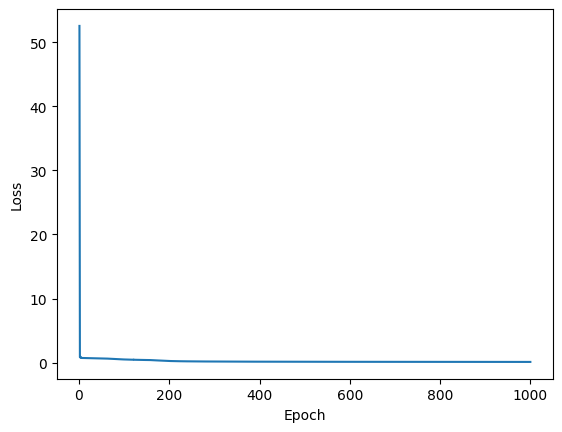

In [140]:
n_features = x_train.shape[1]
torch.manual_seed(42)
model = NN(n_features).to(device)
print(model)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model.parameters(),  lr=0.002)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, threshold=0.0001)

EPOCH = 1000
t_start = time.time()
model, loss_dict = train(model, optimizer, loss_fn, scheduler, x_train, y_train, EPOCH)
t_end = time.time()
print(f"Training Time: {int(t_end - t_start)} seconds")

x_coord, y_coord = zip(*(loss_dict.items()))
if device == "cuda":
    y_coord = tuple(t.item() for t in y_coord)
plt.plot(x_coord,y_coord)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [38]:
def accuracy(model, x, y):
    x, y = x.to(device), y.to(device)
    t_start = time.time()
    out = torch.sigmoid(model(x))
    t_end = time.time()
    print(f"Prediction Time: {(t_end - t_start)} seconds")
    out_list.append(out)
    correct = torch.abs(y - out) < 0.5
    return correct.float().mean(), out

out_list = []
plain_accuracy, op = accuracy(model, x_test_20, y_test_20)
print(f"Accuracy on plain test_set: {plain_accuracy}")

Prediction Time: 0.0010101795196533203 seconds
Accuracy on plain test_set: 0.9589009284973145


In [39]:
op_df = pd.DataFrame({
    "NormalEval": op.squeeze().detach().cpu().numpy()})
op_df.head()

,NormalEval
0,6.009799e-01
1,8.203998e-01
2,3.711469e-08
3,9.999999e-01
4,1.000000e+00


In [40]:
op = op.squeeze().detach().cpu().numpy()
for i in range(len(op)):
    if op[i]<0.5:
        op[i] = 0
    else:
        op[i] = 1
y_test_temp = y_test_20.squeeze().numpy()
plain_accuracy = accuracy_score(y_test_temp, op)
plain_recall = recall_score(y_test_temp, op, average='binary')  
plain_f1 = f1_score(y_test_temp, op, average='binary')  
plain_precision = precision_score(y_test_temp, op, average='binary')  
print(f"Accuracy: {plain_accuracy}")
print(f"Recall: {plain_recall}")
print(f"Precision: {plain_precision}")
print(f"F1 - Score: {plain_f1}")

Accuracy: 0.9589008924377642
Recall: 0.9736098020735156
Precision: 0.9455377574370709
F1 - Score: 0.9593684699326678


In [89]:
from pathlib import Path
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
MODEL_NAME = "ann_3layers.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

In [90]:
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH) 

Saving model to: models\ann_3layers.pth


In [91]:
model = NN(40).to(device)
model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [14]:
class EncryptedANN:
    
    def __init__(self, torch_ann):
        self.layer_1_weight = torch_ann.layer_1.weight.T.data.tolist()
        self.layer_1_bias = torch_ann.layer_1.bias.data.tolist()

        self.layer_2_weight = torch_ann.layer_2.weight.T.data.tolist()
        self.layer_2_bias = torch_ann.layer_2.bias.data.tolist()
        
        self.layer_3_weight = torch_ann.layer_3.weight.T.data.tolist()
        self.layer_3_bias = torch_ann.layer_3.bias.data.tolist()
        
    def forward(self, enc_x):
        enc_x = enc_x.mm(self.layer_1_weight) + self.layer_1_bias
        enc_x.square_()
        
        enc_x = enc_x.mm(self.layer_2_weight) + self.layer_2_bias
        enc_x.square_()
                
        enc_x = enc_x.mm(self.layer_3_weight) + self.layer_3_bias
        
        return enc_x
    
    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)
    
#     def encrypt(self, context):
#         self.weight = ts.ckks_vector(context, self.weight)
#         self.bias = ts.ckks_vector(context, self.bias)
        
#     def decrypt(self, context):
#         self.weight = self.weight.decrypt()
#         self.bias = self.bias.decrypt()
        
eelr = EncryptedANN(model)

In [74]:
poly_mod_degree = 16384
bits_scale = 40
integer_scale = 60
coeff_mod_bit_sizes = [integer_scale, bits_scale, bits_scale, bits_scale, bits_scale, bits_scale, integer_scale]
ctx_eval = ts.context(ts.SCHEME_TYPE.CKKS, poly_mod_degree, -1, coeff_mod_bit_sizes)
ctx_eval.global_scale = 2 ** bits_scale
ctx_eval.generate_galois_keys()

In [75]:
def encrypted_evaluation(model, enc_x_test, y_test):
    t_start = time.time()
    output_list = []
    correct = 0
    for enc_x, y in zip(enc_x_test, y_test):
        enc_out = model(enc_x)
        out = enc_out.decrypt()
        out = torch.tensor(out)
        out = torch.sigmoid(out)
        if torch.abs(out - y) < 0.5:
            correct += 1
        output_list.append(out)
    t_end = time.time()
    print(f"Evaluated test set of {len(enc_x_test)} entries in {int(t_end - t_start)} seconds")
    print(f"Score: {correct}/{len(enc_x_test)}")
    return correct / len(enc_x_test), output_list

In [82]:
y_pred_final = []
one_part = y_test_20.shape[0] // 20
for i in range(1, 21):
    if i==1:
        j = one_part
        temp_x_test = x_test_20[:j,]
        temp_y_test = y_test_20[:j,]
    elif i==20:
        j = one_part * (i-1)
        temp_x_test = x_test_20[j:,]
        temp_y_test = y_test_20[j:,]
    else:
        j = one_part * i
        if i == 1:
            k = one_part
        else:
            k = one_part * (i-1)
        temp_x_test = x_test_20[k:j,]
        temp_y_test = y_test_20[k:j,]
    
    t_start = time.time()
    enc_x_test = []
    print(f"Starting Batch {i} Encryption")
    for x in tqdm(range(len(temp_x_test))):
        enc_x_test.append(ts.ckks_vector(ctx_eval, temp_x_test[x].tolist()))
    t_end = time.time()
    print(f"Encryption of the test set took {int(t_end - t_start)} seconds")
    encrypted_accuracy, output_list = encrypted_evaluation(eelr, enc_x_test, temp_y_test)
    print(f"Batch {i} Encrypted Accuracy: {encrypted_accuracy}")
    y_pred = torch.cat(output_list)
    y_pred = y_pred.numpy()
    y_pred_final.extend(y_pred)

Starting Batch 1 Encryption


100%|████████████████████████████████████████████████████████████████████████████████| 212/212 [00:03<00:00, 63.42it/s]


Encryption of the test set took 3 seconds
Evaluated test set of 212 entries in 112 seconds
Score: 198/212
Batch 1 Encrypted Accuracy: 0.9339622641509434
Starting Batch 2 Encryption


100%|████████████████████████████████████████████████████████████████████████████████| 212/212 [00:03<00:00, 54.08it/s]


Encryption of the test set took 3 seconds
Evaluated test set of 212 entries in 115 seconds
Score: 201/212
Batch 2 Encrypted Accuracy: 0.9481132075471698
Starting Batch 3 Encryption


100%|████████████████████████████████████████████████████████████████████████████████| 212/212 [00:03<00:00, 59.11it/s]


Encryption of the test set took 3 seconds
Evaluated test set of 212 entries in 115 seconds
Score: 204/212
Batch 3 Encrypted Accuracy: 0.9622641509433962
Starting Batch 4 Encryption


100%|████████████████████████████████████████████████████████████████████████████████| 212/212 [00:03<00:00, 59.24it/s]


Encryption of the test set took 3 seconds
Evaluated test set of 212 entries in 116 seconds
Score: 197/212
Batch 4 Encrypted Accuracy: 0.9292452830188679
Starting Batch 5 Encryption


100%|████████████████████████████████████████████████████████████████████████████████| 212/212 [00:03<00:00, 58.93it/s]


Encryption of the test set took 3 seconds
Evaluated test set of 212 entries in 116 seconds
Score: 199/212
Batch 5 Encrypted Accuracy: 0.9386792452830188
Starting Batch 6 Encryption


100%|████████████████████████████████████████████████████████████████████████████████| 212/212 [00:03<00:00, 59.12it/s]


Encryption of the test set took 3 seconds
Evaluated test set of 212 entries in 116 seconds
Score: 197/212
Batch 6 Encrypted Accuracy: 0.9292452830188679
Starting Batch 7 Encryption


100%|████████████████████████████████████████████████████████████████████████████████| 212/212 [00:03<00:00, 59.09it/s]


Encryption of the test set took 3 seconds
Evaluated test set of 212 entries in 117 seconds
Score: 206/212
Batch 7 Encrypted Accuracy: 0.9716981132075472
Starting Batch 8 Encryption


100%|████████████████████████████████████████████████████████████████████████████████| 212/212 [00:03<00:00, 58.87it/s]


Encryption of the test set took 3 seconds
Evaluated test set of 212 entries in 117 seconds
Score: 203/212
Batch 8 Encrypted Accuracy: 0.9575471698113207
Starting Batch 9 Encryption


100%|████████████████████████████████████████████████████████████████████████████████| 212/212 [00:03<00:00, 59.06it/s]


Encryption of the test set took 3 seconds
Evaluated test set of 212 entries in 116 seconds
Score: 196/212
Batch 9 Encrypted Accuracy: 0.9245283018867925
Starting Batch 10 Encryption


100%|████████████████████████████████████████████████████████████████████████████████| 212/212 [00:03<00:00, 58.69it/s]


Encryption of the test set took 3 seconds
Evaluated test set of 212 entries in 117 seconds
Score: 197/212
Batch 10 Encrypted Accuracy: 0.9292452830188679
Starting Batch 11 Encryption


100%|████████████████████████████████████████████████████████████████████████████████| 212/212 [00:03<00:00, 58.44it/s]


Encryption of the test set took 3 seconds
Evaluated test set of 212 entries in 117 seconds
Score: 203/212
Batch 11 Encrypted Accuracy: 0.9575471698113207
Starting Batch 12 Encryption


100%|████████████████████████████████████████████████████████████████████████████████| 212/212 [00:03<00:00, 58.63it/s]


Encryption of the test set took 3 seconds
Evaluated test set of 212 entries in 117 seconds
Score: 199/212
Batch 12 Encrypted Accuracy: 0.9386792452830188
Starting Batch 13 Encryption


100%|████████████████████████████████████████████████████████████████████████████████| 212/212 [00:03<00:00, 59.20it/s]


Encryption of the test set took 3 seconds
Evaluated test set of 212 entries in 117 seconds
Score: 194/212
Batch 13 Encrypted Accuracy: 0.9150943396226415
Starting Batch 14 Encryption


100%|████████████████████████████████████████████████████████████████████████████████| 212/212 [00:03<00:00, 58.88it/s]


Encryption of the test set took 3 seconds
Evaluated test set of 212 entries in 117 seconds
Score: 203/212
Batch 14 Encrypted Accuracy: 0.9575471698113207
Starting Batch 15 Encryption


100%|████████████████████████████████████████████████████████████████████████████████| 212/212 [00:03<00:00, 58.72it/s]


Encryption of the test set took 3 seconds
Evaluated test set of 212 entries in 115 seconds
Score: 203/212
Batch 15 Encrypted Accuracy: 0.9575471698113207
Starting Batch 16 Encryption


100%|████████████████████████████████████████████████████████████████████████████████| 212/212 [00:03<00:00, 59.48it/s]


Encryption of the test set took 3 seconds
Evaluated test set of 212 entries in 120 seconds
Score: 207/212
Batch 16 Encrypted Accuracy: 0.9764150943396226
Starting Batch 17 Encryption


100%|████████████████████████████████████████████████████████████████████████████████| 212/212 [00:03<00:00, 57.93it/s]


Encryption of the test set took 3 seconds
Evaluated test set of 212 entries in 130 seconds
Score: 196/212
Batch 17 Encrypted Accuracy: 0.9245283018867925
Starting Batch 18 Encryption


100%|████████████████████████████████████████████████████████████████████████████████| 212/212 [00:04<00:00, 52.29it/s]


Encryption of the test set took 4 seconds
Evaluated test set of 212 entries in 129 seconds
Score: 203/212
Batch 18 Encrypted Accuracy: 0.9575471698113207
Starting Batch 19 Encryption


100%|████████████████████████████████████████████████████████████████████████████████| 212/212 [00:03<00:00, 58.56it/s]


Encryption of the test set took 3 seconds
Evaluated test set of 212 entries in 126 seconds
Score: 204/212
Batch 19 Encrypted Accuracy: 0.9622641509433962
Starting Batch 20 Encryption


100%|████████████████████████████████████████████████████████████████████████████████| 230/230 [00:04<00:00, 53.28it/s]


Encryption of the test set took 4 seconds
Evaluated test set of 230 entries in 129 seconds
Score: 218/230
Batch 20 Encrypted Accuracy: 0.9478260869565217


In [84]:
op_df["HEEval"] = y_pred_final

In [85]:
y_pred_final_temp = y_pred_final
for i in range(len(y_pred_final)):
    if y_pred_final[i]<0.5:
        y_pred_final[i] = 0
    else:
        y_pred_final[i] = 1
y_test_temp = y_test_20.squeeze().numpy()
enc_accuracy = accuracy_score(y_test_temp, y_pred_final)
enc_recall = recall_score(y_test_temp, y_pred_final, average='binary')
enc_f1 = f1_score(y_test_temp, y_pred_final, average='binary')
enc_precision = precision_score(y_test_temp, y_pred_final, average='binary')
print(f"Accuracy: {enc_accuracy}")
print(f"Recall: {enc_recall}")
print(f"Precision: {enc_precision}")
print(f"F1 - Score: {enc_f1}")

Accuracy: 0.9459840300610616
Recall: 0.9877474081055608
Precision: 0.9113043478260869
F1 - Score: 0.9479873360470376


In [87]:
op_df

,NormalEval,HEEval
0,6.009799e-01,8.147911e-01
1,8.203998e-01,9.904236e-01
2,3.711469e-08,7.161893e-07
3,9.999999e-01,9.999995e-01
4,1.000000e+00,1.000000e+00
...,...,...
4253,2.892018e-05,4.812529e-02
4254,3.913748e-13,2.185575e-12
4255,1.000000e+00,1.000000e+00
4256,9.563541e-01,9.997515e-01


In [32]:
op_df.to_csv("NormalHEEval.csv", index=False)

In [88]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(op_df['NormalEval'], op_df['HEEval'])
print("Mean Absolute Error:", mae)

Mean Absolute Error: 0.050171107
